In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import akantu as aka
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh

In [3]:
mesh_file = 'mesh/contact3d_sphere.msh'
material_file = 'material/material.dat'
spatial_dimension = 3
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._triangle_3)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, model, positions, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary)

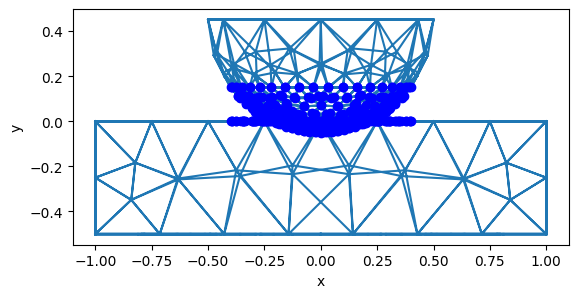

----> Starting iteration 1 <----
Interpenetrating nodes:  []
Nodes in tension:  [ 12  13  14  15  18  20  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 115 116 117 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 368 369 376 377 378 379 387 394 396 397 399
 400 402 409 410 411 412 413 414 416 424 429 430 431 432 433 435 436 449
 454 455 456 457 460 461 462 463 472 473 474 475 476 477 478 479 484 485
 486 490 491 492 493 494 496 497 498 502 505 513 514 515 516 518 537 538
 541 542 543 544 545 546 547 551 554 557 561 563 565 567 568 569 570 571
 572 573 579 580 583 584 585 589 592 600 601 602 603 605 624 629 630 631
 632 633 634 636 637 638 639 640 641 643 644 645 648 650 652 654 655 656
 657]


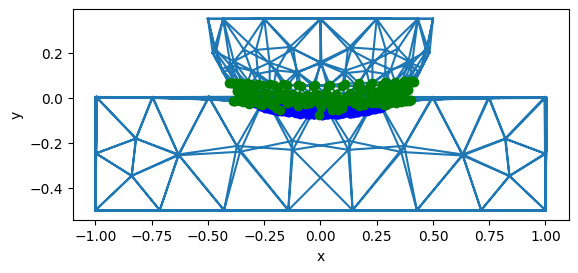

----> Starting iteration 2 <----
Interpenetrating nodes:  []
Nodes in tension:  [386 388 415 467 468 489 555 574 576 578 581 582 586 623 628 642]


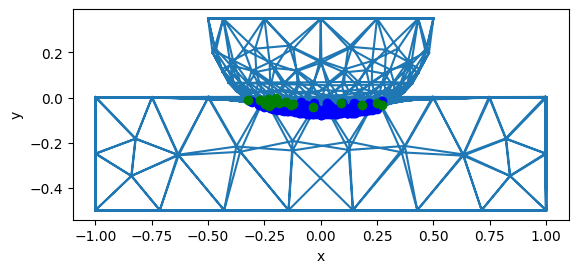

----> Starting iteration 3 <----
Interpenetrating nodes:  []
Nodes in tension:  [372 380 395 553]


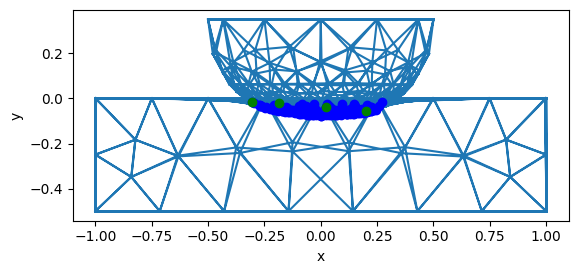

----> Starting iteration 4 <----
Interpenetrating nodes:  []
Nodes in tension:  [503]


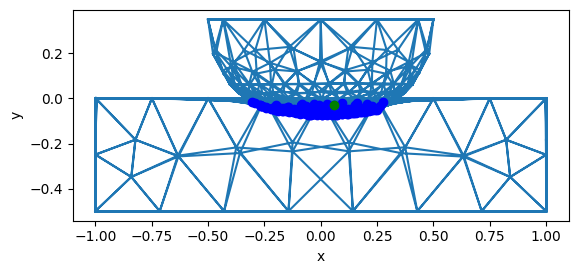

----> Starting iteration 5 <----
Interpenetrating nodes:  []
Nodes in tension:  [434]


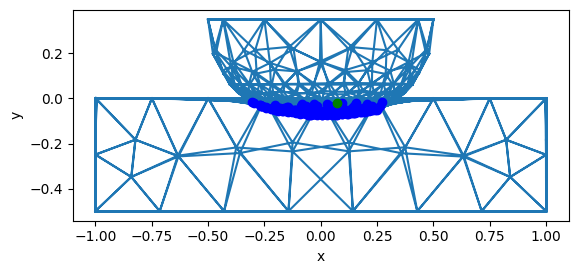


successfully converged in 5 iterations


In [4]:
# Plot initial configuration
nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
plot_mesh(internodes_model.nodal_positions, internodes_model.surface_connectivity, nodes_interface)

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    nodes_interface_primary_old = internodes_model.nodes_interface_primary
    nodes_interface_secondary_old = internodes_model.nodes_interface_secondary

    # Find the interface nodes
    internodes_model.find_interface_nodes()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged = internodes_model.update_interface(displacements, lambdas)

    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    nodes_interpenetrating = np.union1d(
        np.setdiff1d(internodes_model.nodes_interface_primary, nodes_interface_primary_old),
        np.setdiff1d(internodes_model.nodes_interface_secondary, nodes_interface_secondary_old))
    nodes_tension = np.union1d(
        np.setdiff1d(nodes_interface_primary_old, internodes_model.nodes_interface_primary),
        np.setdiff1d(nodes_interface_secondary_old, internodes_model.nodes_interface_secondary))
    print("Interpenetrating nodes: ", nodes_interpenetrating)
    print("Nodes in tension: ", nodes_tension)

    # Plot the obtained solution
    positions_new = internodes_model.nodal_positions + displacements
    plot_mesh(positions_new, internodes_model.surface_connectivity, nodes_interface, nodes_interpenetrating, nodes_tension)

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break